In [1]:
import numpy as np 
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# We do this to align plots at the center
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
# Import Dataset from the NEDL google drive
url = 'https://drive.usercontent.google.com/download?id=1floGmqRy7mE8e-F9PKmHWDm_ALGJGu73&export=download&confirm=t&uuid=5a1eceae-e9da-46f2-95eb-c3900511abd2'
df = pd.read_excel(url, sheet_name='Logit')

In [4]:
# Clean dataset
# Remove unnecesary columns and use first row as headers

df.drop(df.index[0:6], inplace=True)
df.reset_index(drop=True, inplace=True)
df.columns = df.iloc[0]

df = df.iloc[1:]
df = df.iloc[0:500]

df.drop('id', axis=1, inplace=True)
df = df.iloc[:,0:16]
df.drop(df.columns[4:11], axis=1, inplace=True)

df.reset_index(drop=True, inplace=True)
df.index.name = 'ID'
df.head()

,Default,Constant,Homeowner,Employed,Income,Expenses,Assets,Debt,Loan amount
ID,,,,,,,,,
0,0,1,0,0,129,73,0,0,800
1,0,1,0,1,131,48,0,0,1000
2,1,1,1,0,200,90,3000,0,2000
3,0,1,0,1,182,63,2500,0,900
4,0,1,0,1,107,46,0,0,310


In [5]:
# Let's examine the data types
df.dtypes

0
Default        object
Constant       object
Homeowner      object
Employed       object
Income         object
Expenses       object
Assets         object
Debt           object
Loan amount    object
dtype: object

In [6]:
# Covert variables from object to int
df = df.astype(str).astype(int)
df.dtypes

0
Default        int32
Constant       int32
Homeowner      int32
Employed       int32
Income         int32
Expenses       int32
Assets         int32
Debt           int32
Loan amount    int32
dtype: object

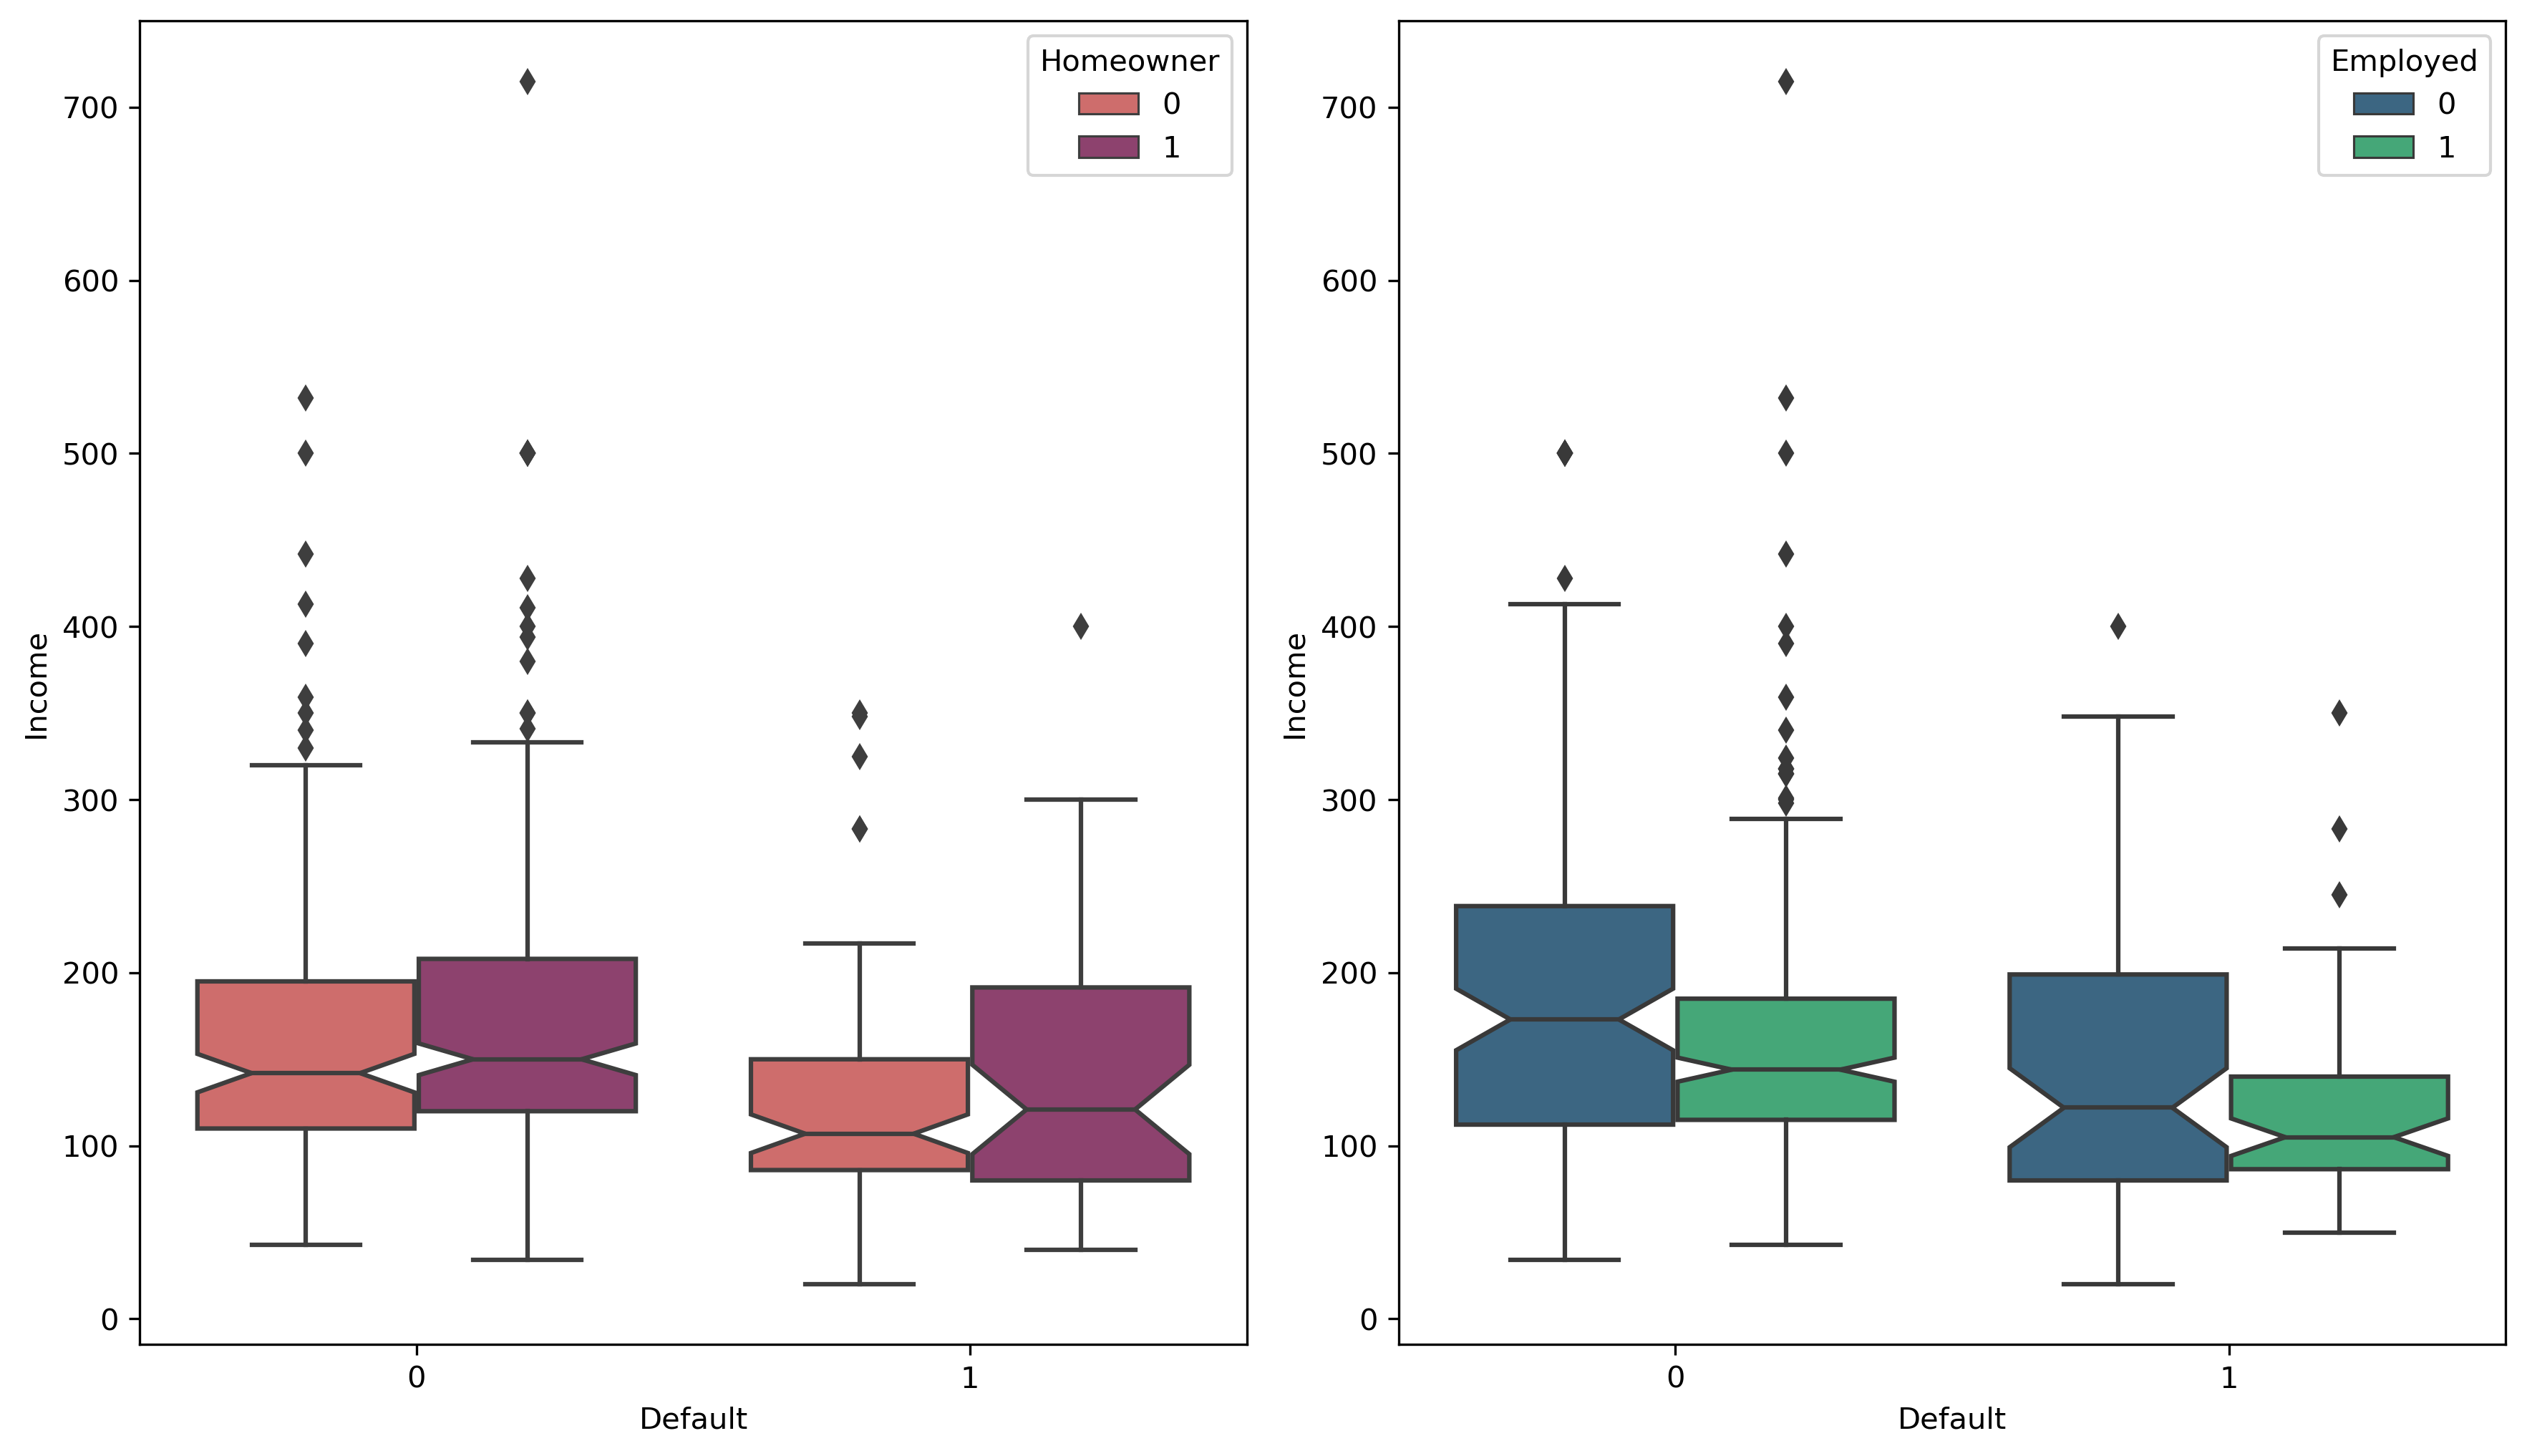

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12,7), dpi=300)

fig.tight_layout(pad=2.0)

sns.color_palette("flare")
sns.boxplot(data=df, x='Default', y='Income', hue='Homeowner', ax=axes[0], palette='flare', notch=True)
sns.boxplot(data=df, x='Default', y='Income', hue='Employed', ax=axes[1], palette='viridis', notch=True)

plt.show()

In [8]:
# Let's further divide the boxplots
DH = []

for i in range(len(df)):
    if df['Default'][i]==0 and df['Homeowner'][i]==0:
        DH.append('No Default—No Home')
    if df['Default'][i]==0 and df['Homeowner'][i]==1:
        DH.append('No Default—Homeowner')
    if df['Default'][i]==1 and df['Homeowner'][i]==0:
        DH.append('Default—No Home')
    elif df['Default'][i]==1 and df['Homeowner'][i]==1:
        DH.append('Default—Homeowner')

df['Default x Homeowner'] = DH

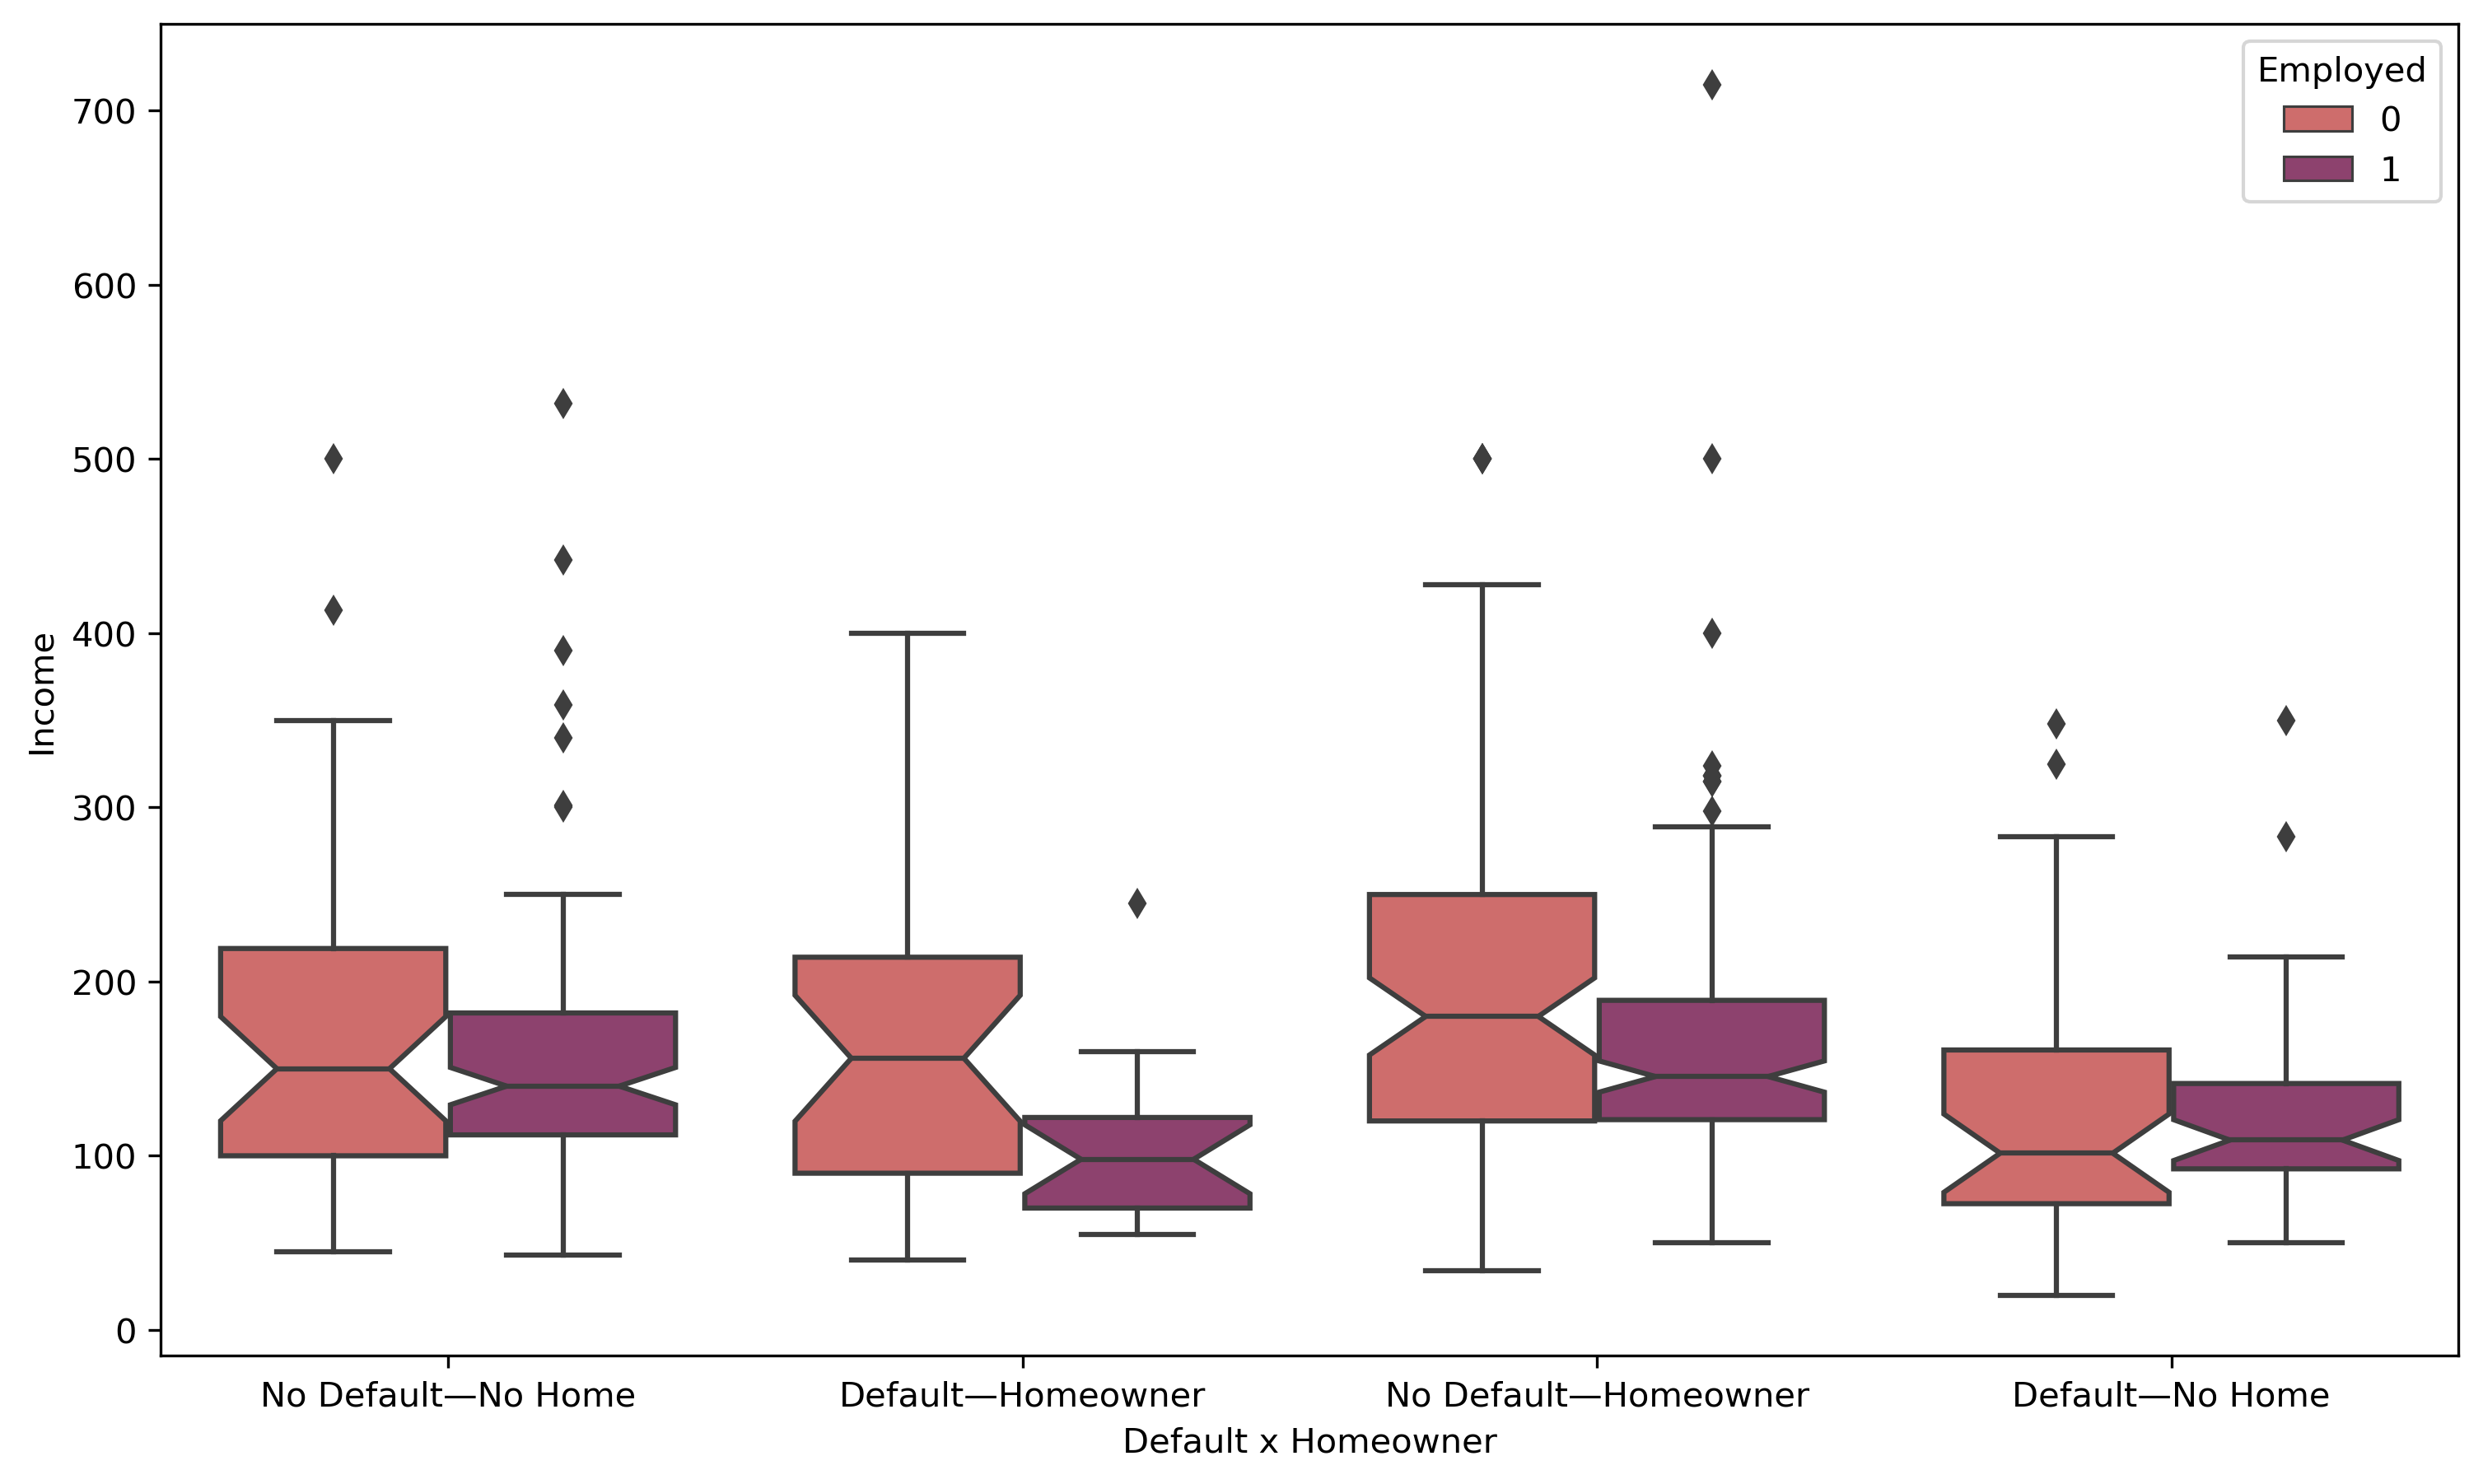

In [9]:
# Make a boxplot with a further division of clases
plt.figure(figsize=(12,7), dpi=300)
sns.boxplot(data=df, x='Default x Homeowner', y='Income', hue='Employed', palette='flare', notch=True)
plt.xticks(rotation=0)
plt.show()

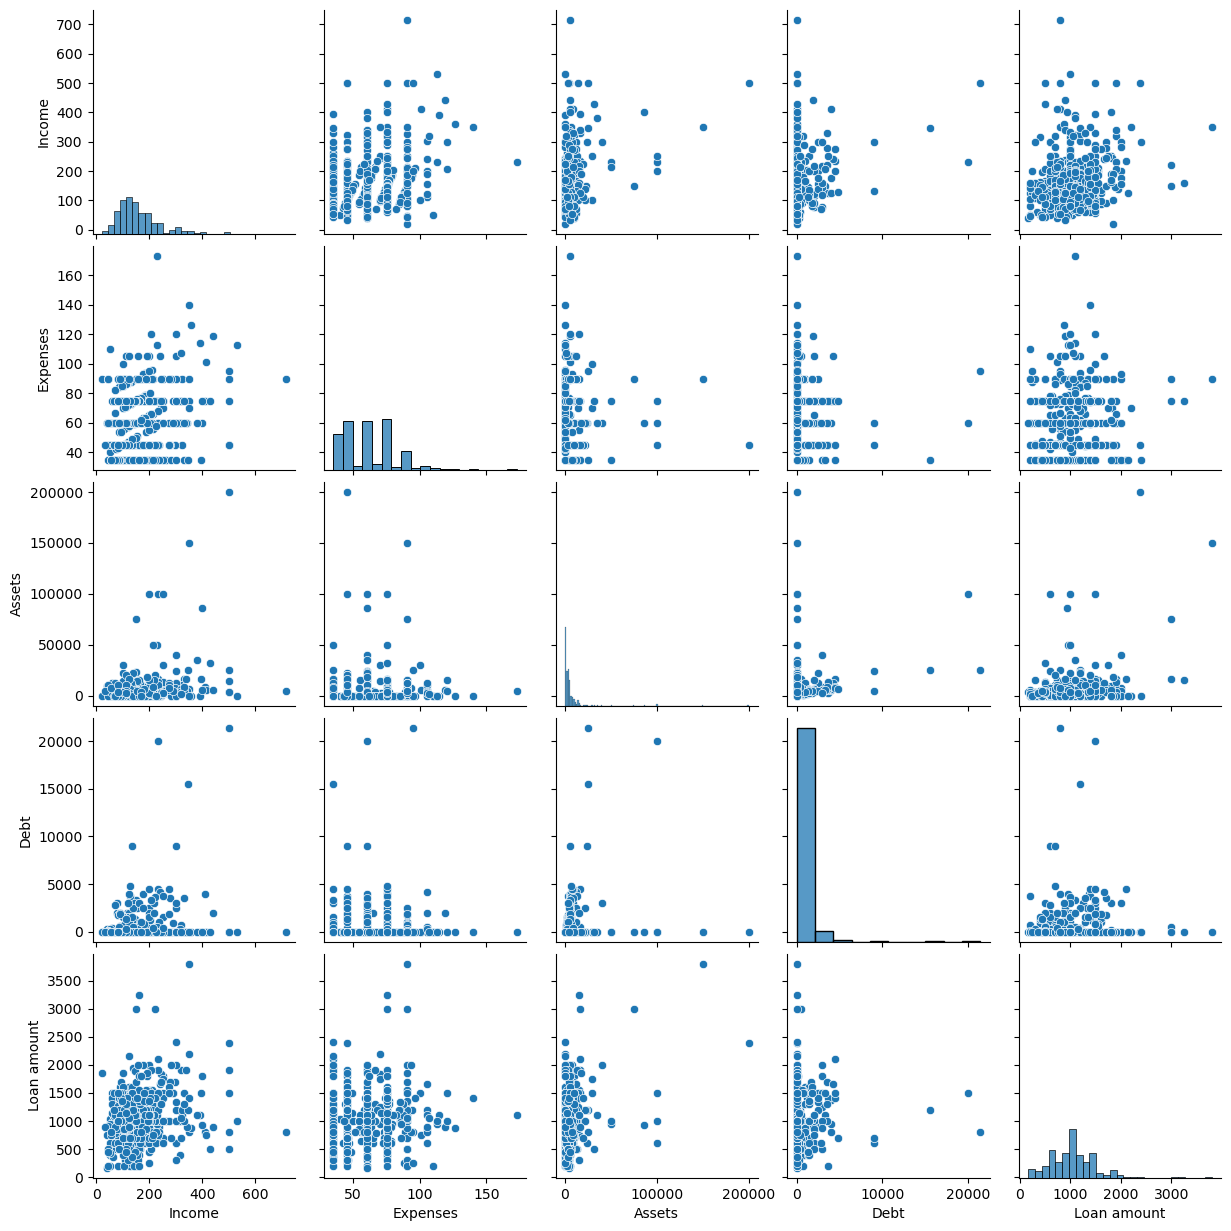

In [10]:
# Make a pairplot with continous variables only
df0 = df.drop(['Default', 'Constant', 'Homeowner', 'Employed'], axis=1)
sns.pairplot(df0)
plt.show()

In [11]:
# Create three sets of predicting and predicted variables
Y = df['Default']
X = df.drop(['Default','Default x Homeowner'], axis=1)

# Set of transformed predicting variables
X1 = X.copy()
X1['log(E/I)'] = np.log(X1['Expenses']/X1['Income'])
X1['log(D/A)'] = np.log((X1['Debt']+X1['Loan amount'])/(X1['Assets']+X1['Loan amount']))
X1['log(LA/I)'] = np.log(X1['Loan amount']/X1['Income'])
#Remove original variables
X1.drop(['Income', 'Expenses', 'Assets', 'Debt', 'Loan amount'], axis=1, inplace=True)

# Set of transformed predicting variables plus original predicitng variables
X2 = X.loc[:]
X2['log(E/I)'] = np.log(X2['Expenses']/X2['Income'])
X2['log(D/A)'] = np.log((X2['Debt']+X2['Loan amount'])/(X2['Assets']+X2['Loan amount']))
X2['log(LA/I)'] = np.log(X2['Loan amount']/X2['Income'])

In [12]:
# Normalise sets of variables leaving the constant column unchanged
# That'll give another three sets of predicting variables
scale = StandardScaler()
x = scale.fit(X).transform(X)
x[:,0] = 1

x1 = scale.fit(X1).transform(X1)
x1[:,0] = 1

x2 = scale.fit(X2).transform(X2)
x2[:,0] = 1

In [13]:
model0 = LogisticRegression(fit_intercept = False, solver='newton-cholesky', penalty=None)
model0 = model0.fit(X, Y)

y_hat0 = model0.predict(X)
proba0 = model0.predict_proba(X)

a0 = accuracy_score(y_hat0, Y)
j0 = jaccard_score(y_hat0, Y)
f0 = f1_score(y_hat0, Y)
lg0 = log_loss(y_hat0, Y)

tbl0 = pd.DataFrame(model0.coef_).T.rename({0: 'Coefs'}, axis=1)
tbl0['Variable'] = ['Constant', 'Homeowner', 'Employed', 'Income', 'Expenses', 'Assets', 'Debt', 'Loan amount']
tbl0 = tbl0[['Variable', 'Coefs']]
tbl0.set_index('Variable', inplace=True)
tbl0

,Coefs
Variable,
Constant,-0.029091
Homeowner,-1.026809
Employed,-1.130285
Income,-0.010726
Expenses,0.004720
Assets,-0.000035
Debt,0.000214
Loan amount,0.001371


In [14]:
model0_st = LogisticRegression(fit_intercept = False, solver='newton-cholesky', penalty=None)
model0_st = model0_st.fit(x, Y)

y_hat0_st = model0_st.predict(X)
proba0_st = model0_st.predict_proba(X)

a0_st = accuracy_score(y_hat0_st, Y)
j0_st = jaccard_score(y_hat0_st, Y)
f0_st = f1_score(y_hat0_st, Y)
lg0_st = log_loss(y_hat0_st, Y)

tbl0_st = pd.DataFrame(model0_st.coef_).T.rename({0: 'Coefs'}, axis=1)
tbl0_st['Variable'] = ['Constant', 'Homeowner', 'Employed', 'Income', 'Expenses', 'Assets', 'Debt', 'Loan amount']
tbl0_st = tbl0_st[['Variable', 'Coefs']]
tbl0_st.set_index('Variable', inplace=True)
tbl0_st

,Coefs
Variable,
Constant,-1.409801
Homeowner,-0.510969
Employed,-0.549005
Income,-0.937594
Expenses,0.096097
Assets,-0.526614
Debt,0.378242
Loan amount,0.615298


In [15]:
model1 = LogisticRegression(fit_intercept = False, solver='newton-cholesky', penalty=None)
model1 = model1.fit(X1, Y)

y_hat1 = model1.predict(X1)
proba1 = model1.predict_proba(X1)

a1 = accuracy_score(y_hat1, Y)
j1 = jaccard_score(y_hat1, Y)
f1 = f1_score(y_hat1, Y)
lg1 = log_loss(y_hat1, Y)

tbl1 = pd.DataFrame(model1.coef_).T.rename({0: 'Coefs'}, axis=1)
tbl1['Variable'] = ['Constant', 'Homeowner', 'Employed', 'log(E/I)', 'log(D/A)', 'log(LA/I)']
tbl1 = tbl1[['Variable', 'Coefs']]
tbl1.set_index('Variable', inplace=True)
tbl1

,Coefs
Variable,
Constant,-1.070177
Homeowner,-0.374001
Employed,-1.226513
log(E/I),0.432223
log(D/A),0.637779
log(LA/I),0.933851


In [16]:
model1_st = LogisticRegression(fit_intercept = False, solver='newton-cholesky', penalty=None)
model1_st = model1_st.fit(x1, Y)

y_hat1_st = model1_st.predict(x1)
proba1_st = model1_st.predict_proba(x1)

a1_st = accuracy_score(y_hat1_st, Y)
j1_st = jaccard_score(y_hat1_st, Y)
f1_st = f1_score(y_hat1_st, Y)
lg1_st = log_loss(y_hat1_st, Y)

tbl1_st = pd.DataFrame(model1_st.coef_).T.rename({0: 'Coefs'}, axis=1)
tbl1_st['Variable'] = ['Constant', 'Homeowner', 'Employed', 'log(E/I)', 'log(D/A)', 'log(LA/I)']
tbl1_st = tbl1_st[['Variable', 'Coefs']]
tbl1_st.set_index('Variable', inplace=True)
tbl1_st

,Coefs
Variable,
Constant,-1.363570
Homeowner,-0.186063
Employed,-0.595934
log(E/I),0.225233
log(D/A),0.661171
log(LA/I),0.569897


In [17]:
model2 = LogisticRegression(fit_intercept = False, solver='newton-cholesky', penalty=None)
model2 = model2.fit(X2, Y)

y_hat2 = model2.predict(X2)
proba2 = model2.predict_proba(X2)

a2 = accuracy_score(y_hat2, Y)
j2 = jaccard_score(y_hat2, Y)
f2 = f1_score(y_hat2, Y)
lg2 = log_loss(y_hat2, Y)

tbl2 = pd.DataFrame(model2.coef_).T.rename({0: 'Coefs'}, axis=1)
tbl2['Variable'] = ['Constant', 'Homeowner', 'Employed', 'Income','Expenses', 
                    'Assets', 'Debt', 'Loan amount' ,'log(E/I)', 'log(D/A)', 'log(LA/I)']

tbl2 = tbl2[['Variable', 'Coefs']]
tbl2.set_index('Variable', inplace=True)
tbl2

,Coefs
Variable,
Constant,4.187961
Homeowner,-0.584492
Employed,-1.213480
Income,-0.001309
Expenses,-0.032216
Assets,-0.000012
Debt,0.000104
Loan amount,0.002205
log(E/I),2.343591


In [18]:
model2_st = LogisticRegression(fit_intercept = False, solver='newton-cholesky', penalty=None)
model2_st = model2_st.fit(x2, Y)

y_hat2_st = model2_st.predict(x2)
proba2_st = model2_st.predict_proba(x2)

a2_st = accuracy_score(y_hat2_st, Y)
j2_st = jaccard_score(y_hat2_st, Y)
f2_st = f1_score(y_hat2_st, Y)
lg2_st = log_loss(y_hat2_st, Y)

tbl2_st = pd.DataFrame(model2_st.coef_).T.rename({0: 'Coefs'}, axis=1)
tbl2_st['Variable'] = ['Constant', 'Homeowner', 'Employed', 'Income','Expenses', 
                    'Assets', 'Debt', 'Loan amount' ,'log(E/I)', 'log(D/A)', 'log(LA/I)']

tbl2_st = tbl2_st[['Variable', 'Coefs']]
tbl2_st.set_index('Variable', inplace=True)
tbl2_st

,Coefs
Variable,
Constant,-1.408817
Homeowner,-0.290671
Employed,-0.589519
Income,-0.113127
Expenses,-0.657189
Assets,-0.179520
Debt,0.183624
Loan amount,0.989252
log(E/I),1.221590


In [19]:
tbl0.rename({'Coefs':'Log 1'}, axis=1, inplace=True)
tbl1.rename({'Coefs':'Log 2'}, axis=1, inplace=True)
tbl2.rename({'Coefs':'Log 3'}, axis=1, inplace=True)

tbl0_st.rename({'Coefs':'Log 1 (norm)'}, axis=1, inplace=True)
tbl1_st.rename({'Coefs':'Log 2 (norm)' }, axis=1, inplace=True)
tbl2_st.rename({'Coefs':'Log 3 (norm)'}, axis=1, inplace=True)

In [20]:
tbl = pd.concat([tbl0, tbl1, tbl2, tbl0_st, tbl1_st, tbl2_st], axis=1)
tbl.replace(np.nan, "", inplace=True)
tbl

,Log 1,Log 2,Log 3,Log 1 (norm),Log 2 (norm),Log 3 (norm)
Variable,,,,,,
Constant,-0.029091,-1.070177,4.187961,-1.409801,-1.36357,-1.408817
Homeowner,-1.026809,-0.374001,-0.584492,-0.510969,-0.186063,-0.290671
Employed,-1.130285,-1.226513,-1.213480,-0.549005,-0.595934,-0.589519
Income,-0.010726,,-0.001309,-0.937594,,-0.113127
Expenses,0.00472,,-0.032216,0.096097,,-0.657189
Assets,-0.000035,,-0.000012,-0.526614,,-0.179520
Debt,0.000214,,0.000104,0.378242,,0.183624
Loan amount,0.001371,,0.002205,0.615298,,0.989252
log(E/I),,0.432223,2.343591,,0.225233,1.221590


In [21]:
dicc = {'Model': ['Log 1', 'Log 2', 'Log 3', 'Log 1 (norm)', 'Log 2 (norm)', 'Log 3 (norm)'],
        'Accuracy Score': [a0, a1, a2, a0_st, a1_st, a2_st],
       'Jaccard Score': [j0, j1, j2, j0_st, j1_st, j2_st],
       'F1 Score': [f0, f1, f2, f0_st, f1_st, f2_st],
       'log loss': [lg0, lg1, lg2, lg0_st, lg1_st, lg2_st]}

table = pd.DataFrame(dicc).set_index('Model')
table

,Accuracy Score,Jaccard Score,F1 Score,log loss
Model,,,,
Log 1,0.782,0.248276,0.397790,7.857516
Log 2,0.774,0.231293,0.375691,8.145866
Log 3,0.786,0.267123,0.421622,7.713342
Log 1 (norm),0.698,0.316742,0.481100,10.885183
Log 2 (norm),0.774,0.231293,0.375691,8.145866
Log 3 (norm),0.786,0.267123,0.421622,7.713342


In [22]:
print('Model with minimun log loss \n', table['log loss'][table['log loss']==table['log loss'].min()],'\n')
print('Model with maximun F1 score \n', table['F1 Score'][table['F1 Score']==table['F1 Score'].max()],'\n')
print('Model with maximun Jaccard score \n', table['Jaccard Score'][table['Jaccard Score']==table['Jaccard Score'].max()],'\n')
print('Model with maximun Accuracy score \n', table['Accuracy Score'][table['Accuracy Score']==table['Accuracy Score'].max()])

Model with minimun log loss 
 Model
Log 3           7.713342
Log 3 (norm)    7.713342
Name: log loss, dtype: float64 

Model with maximun F1 score 
 Model
Log 1 (norm)    0.4811
Name: F1 Score, dtype: float64 

Model with maximun Jaccard score 
 Model
Log 1 (norm)    0.316742
Name: Jaccard Score, dtype: float64 

Model with maximun Accuracy score 
 Model
Log 3           0.786
Log 3 (norm)    0.786
Name: Accuracy Score, dtype: float64


In [23]:
print('Log 3 and Log 3 (norm) have the smallest Log loss Score:', lg2)
print('Log 1 (norm) has the best F1 Score:', f0_st)
print('Log 1 (norm) has the best Jaccard Score:', j0_st)
print('Log 3 and Log 3 (norm) have the best Accuracy Score:', a2)

Log 3 and Log 3 (norm) have the smallest Log loss Score: 7.713341825271071
Log 1 (norm) has the best F1 Score: 0.4810996563573883
Log 1 (norm) has the best Jaccard Score: 0.3167420814479638
Log 3 and Log 3 (norm) have the best Accuracy Score: 0.786


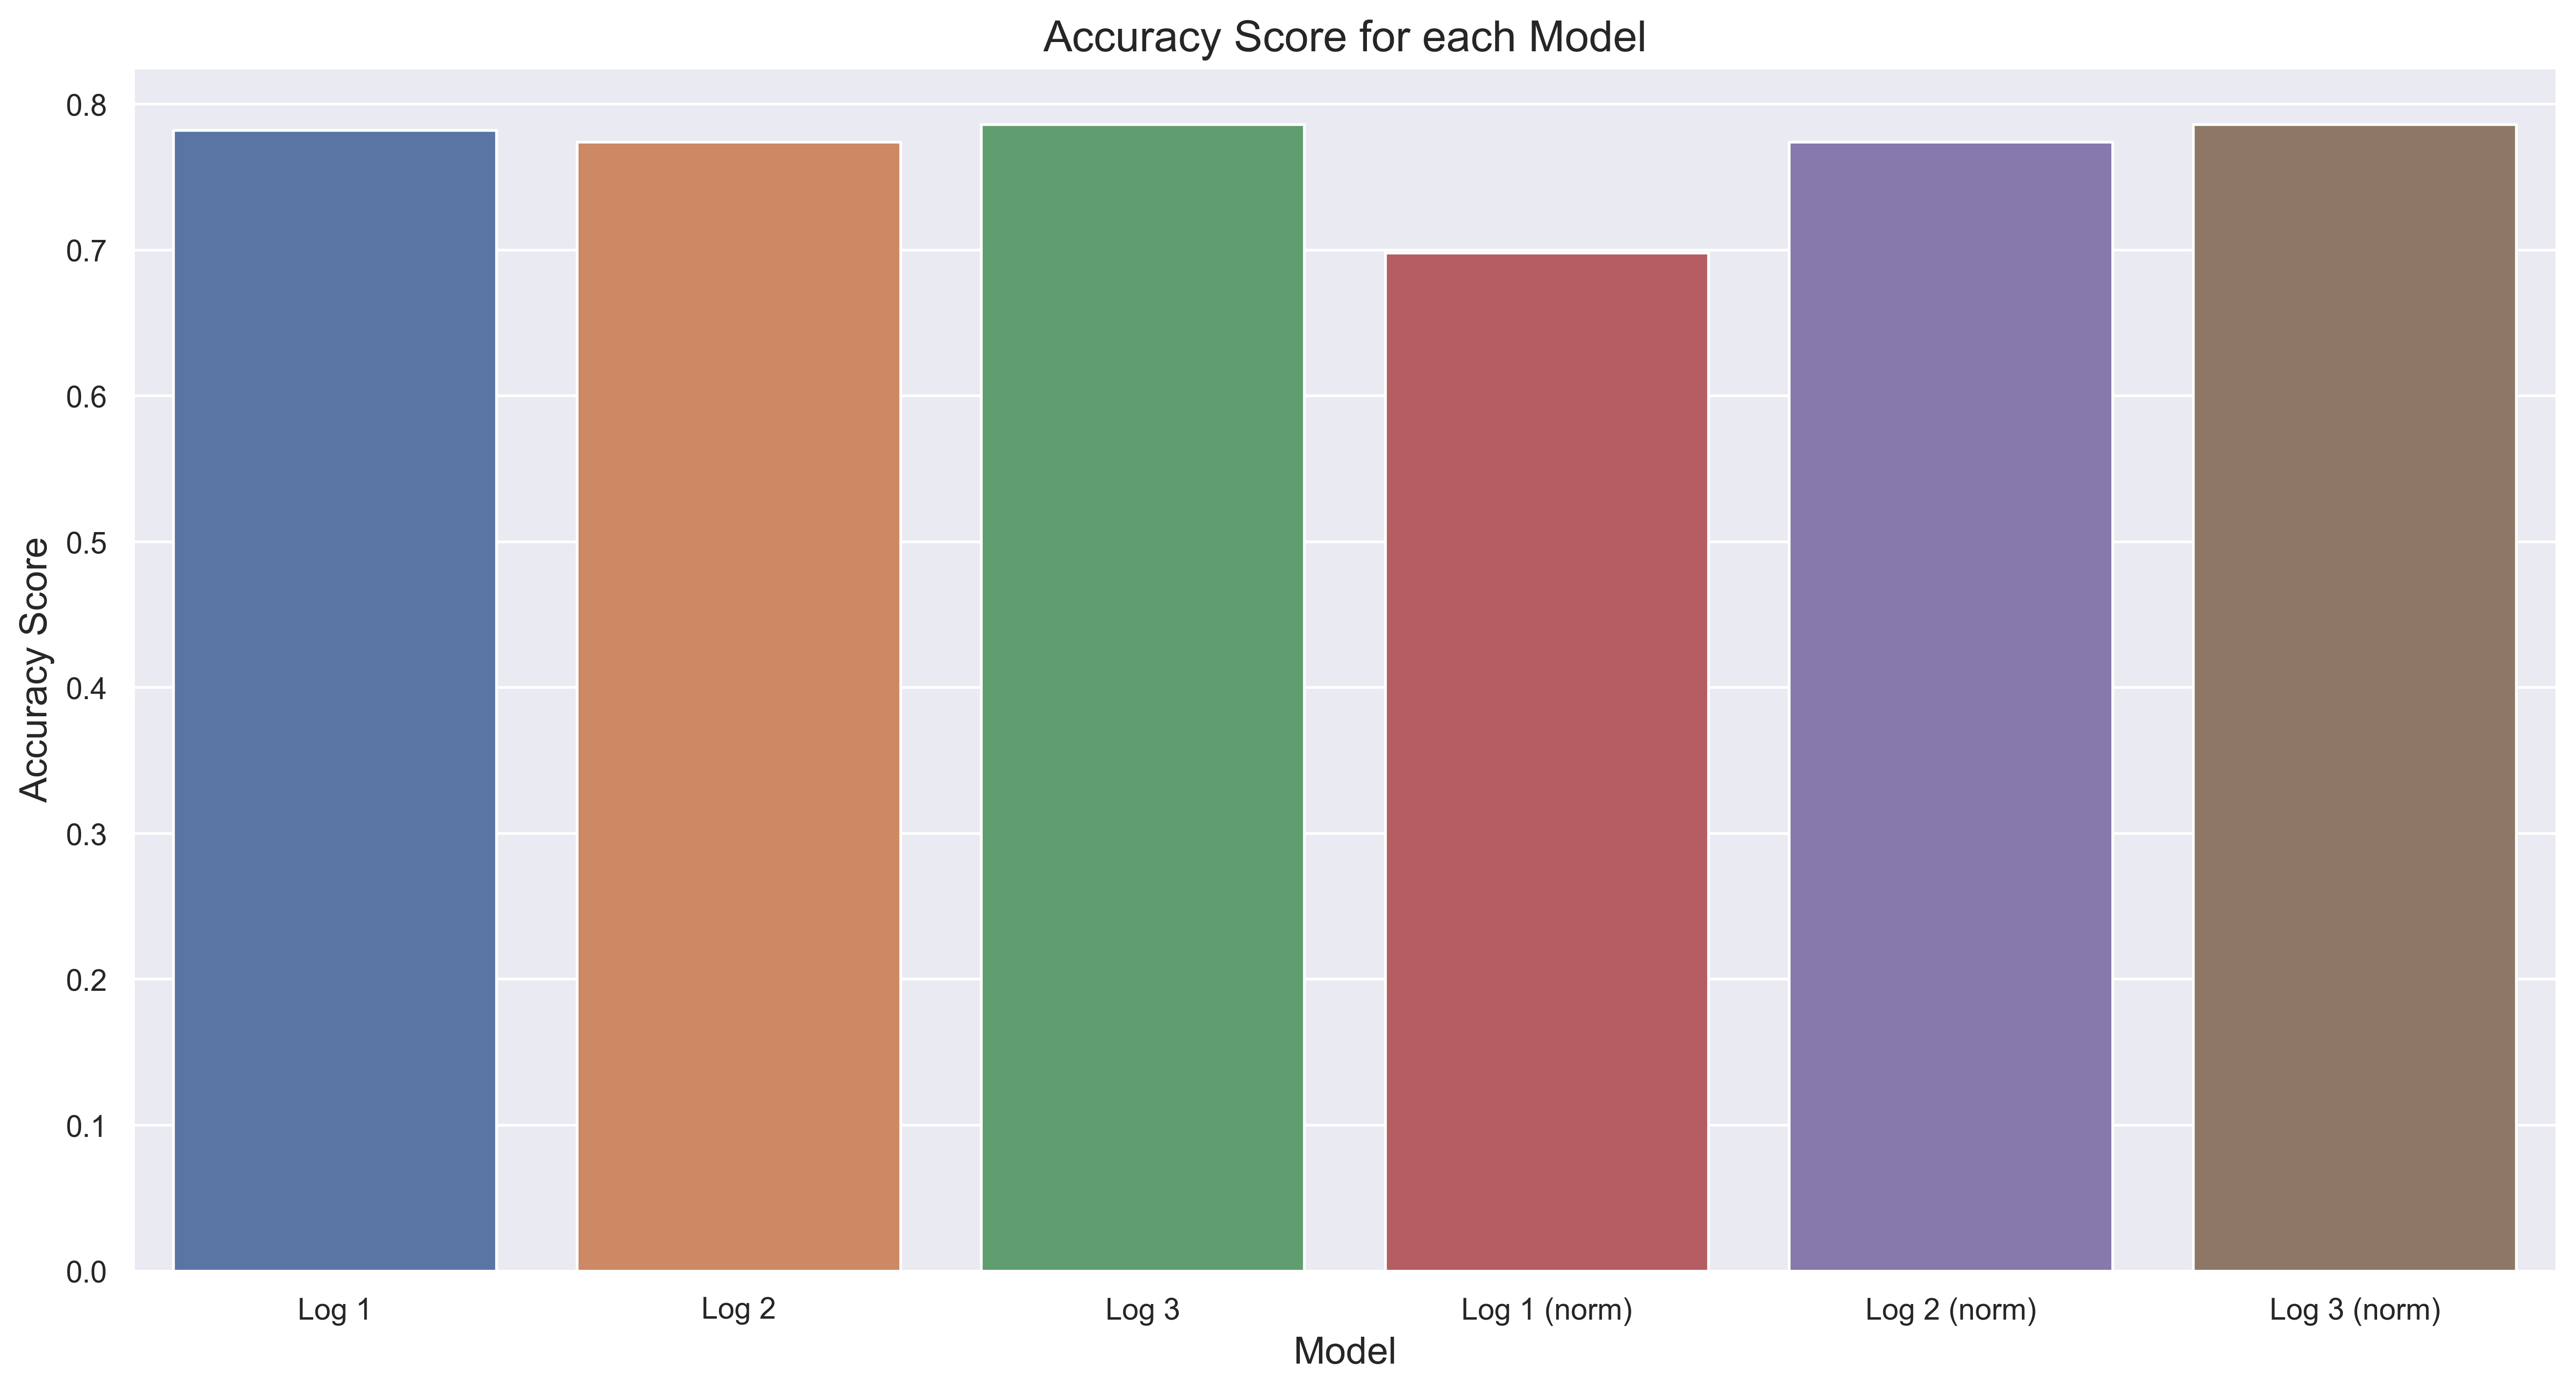

In [24]:

sns.set(rc={'figure.figsize':(16, 8), "figure.dpi":400})
sns.barplot(x=table.index, y='Accuracy Score', data=table)
plt.xlabel('Model', size=14, )
plt.ylabel('Accuracy Score', size=14)
plt.title('Accuracy Score for each Model', size=16)
plt.show()

#

### ROC Score

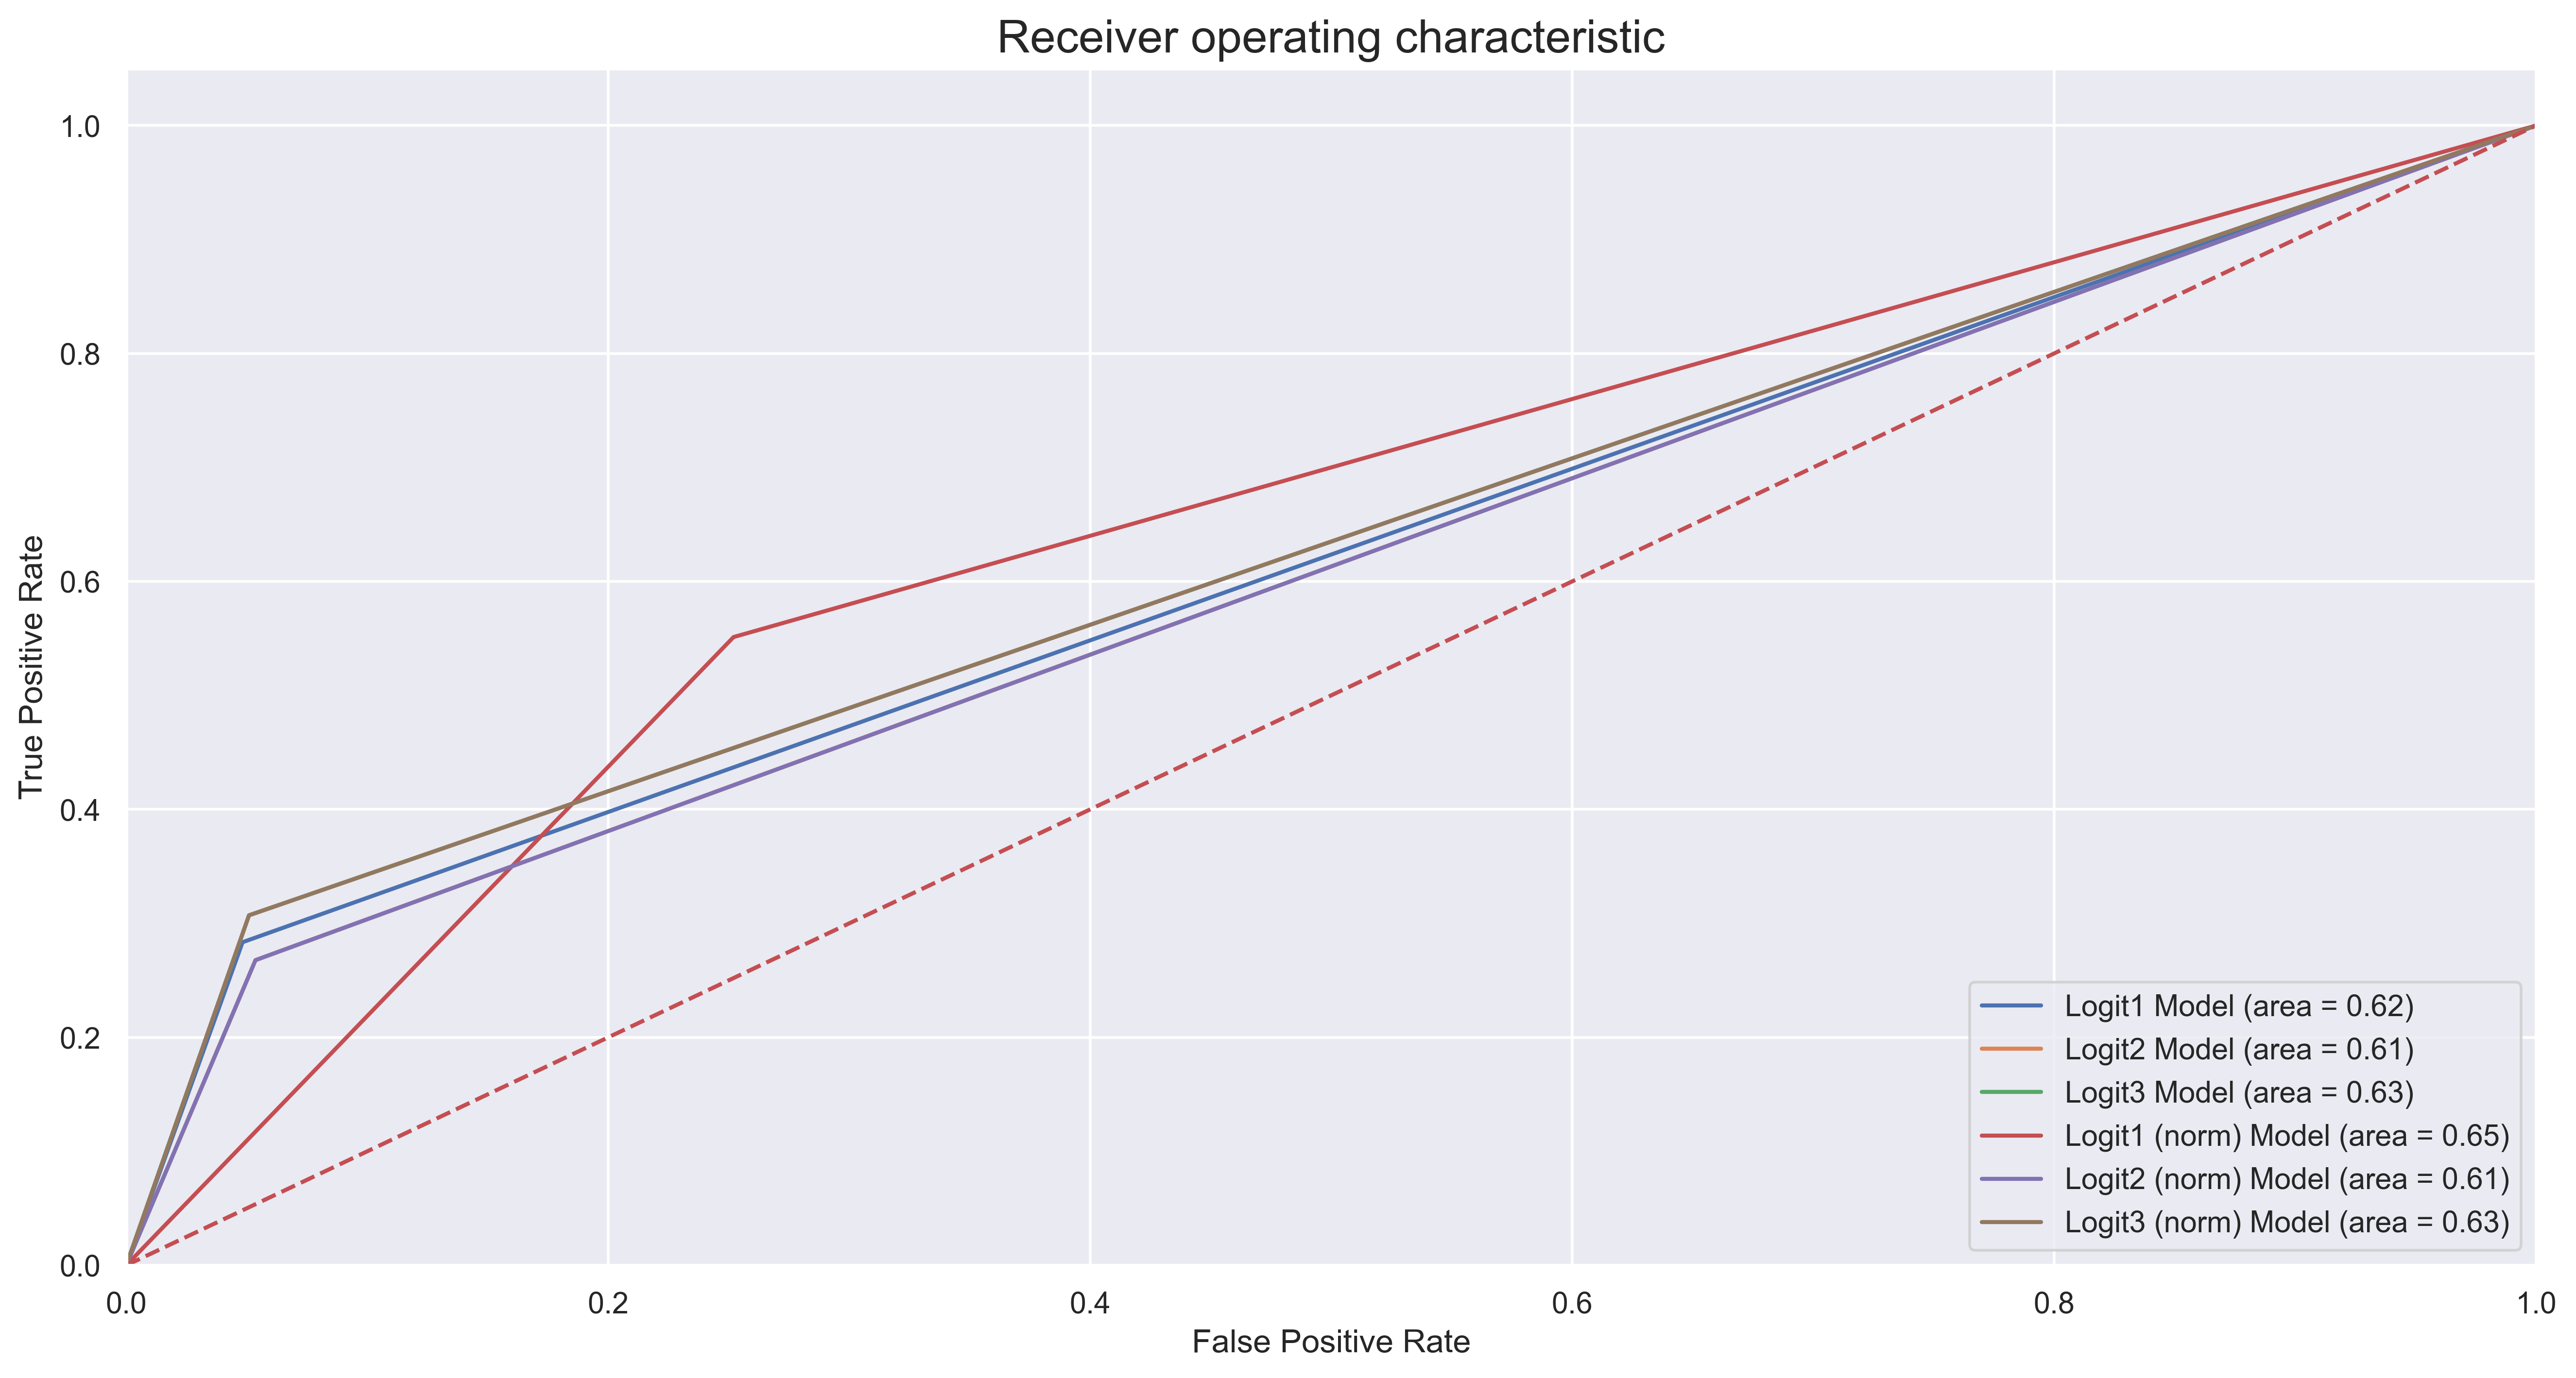

In [25]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 
logit0_roc_auc = roc_auc_score(Y, y_hat0)
logit1_roc_auc = roc_auc_score(Y, y_hat1)
logit2_roc_auc = roc_auc_score(Y, y_hat2)
logit0_st_roc_auc = roc_auc_score(Y, y_hat0_st)
logit1_st_roc_auc = roc_auc_score(Y, y_hat1_st)
logit2_st_roc_auc = roc_auc_score(Y, y_hat2_st)


fpr0, tpr0, thresholds0 = roc_curve(Y, y_hat0)
fpr1, tpr1, thresholds1 = roc_curve(Y, y_hat1)
fpr2, tpr2, thresholds2 = roc_curve(Y, y_hat2)
fpr0_st, tpr0_st, thresholds0_st = roc_curve(Y, y_hat0_st)
fpr1_st, tpr1_st, thresholds1_st = roc_curve(Y, y_hat1_st)
fpr2_st, tpr2_st, thresholds2_st = roc_curve(Y, y_hat2_st)

#plt.figure()
plt.plot(fpr0, tpr0, label='Logit1 Model (area = %0.2f)' % logit0_roc_auc)
plt.plot(fpr1, tpr1, label='Logit2 Model (area = %0.2f)' % logit1_roc_auc)
plt.plot(fpr2, tpr2, label='Logit3 Model (area = %0.2f)' % logit2_roc_auc)
plt.plot(fpr0_st, tpr0_st, label='Logit1 (norm) Model (area = %0.2f)' % logit0_st_roc_auc)
plt.plot(fpr1_st, tpr1_st, label='Logit2 (norm) Model (area = %0.2f)' % logit1_st_roc_auc)
plt.plot(fpr2_st, tpr2_st, label='Logit3 (norm) Model (area = %0.2f)' % logit2_st_roc_auc)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic', size=17)
plt.legend(loc="lower right")


plt.show()

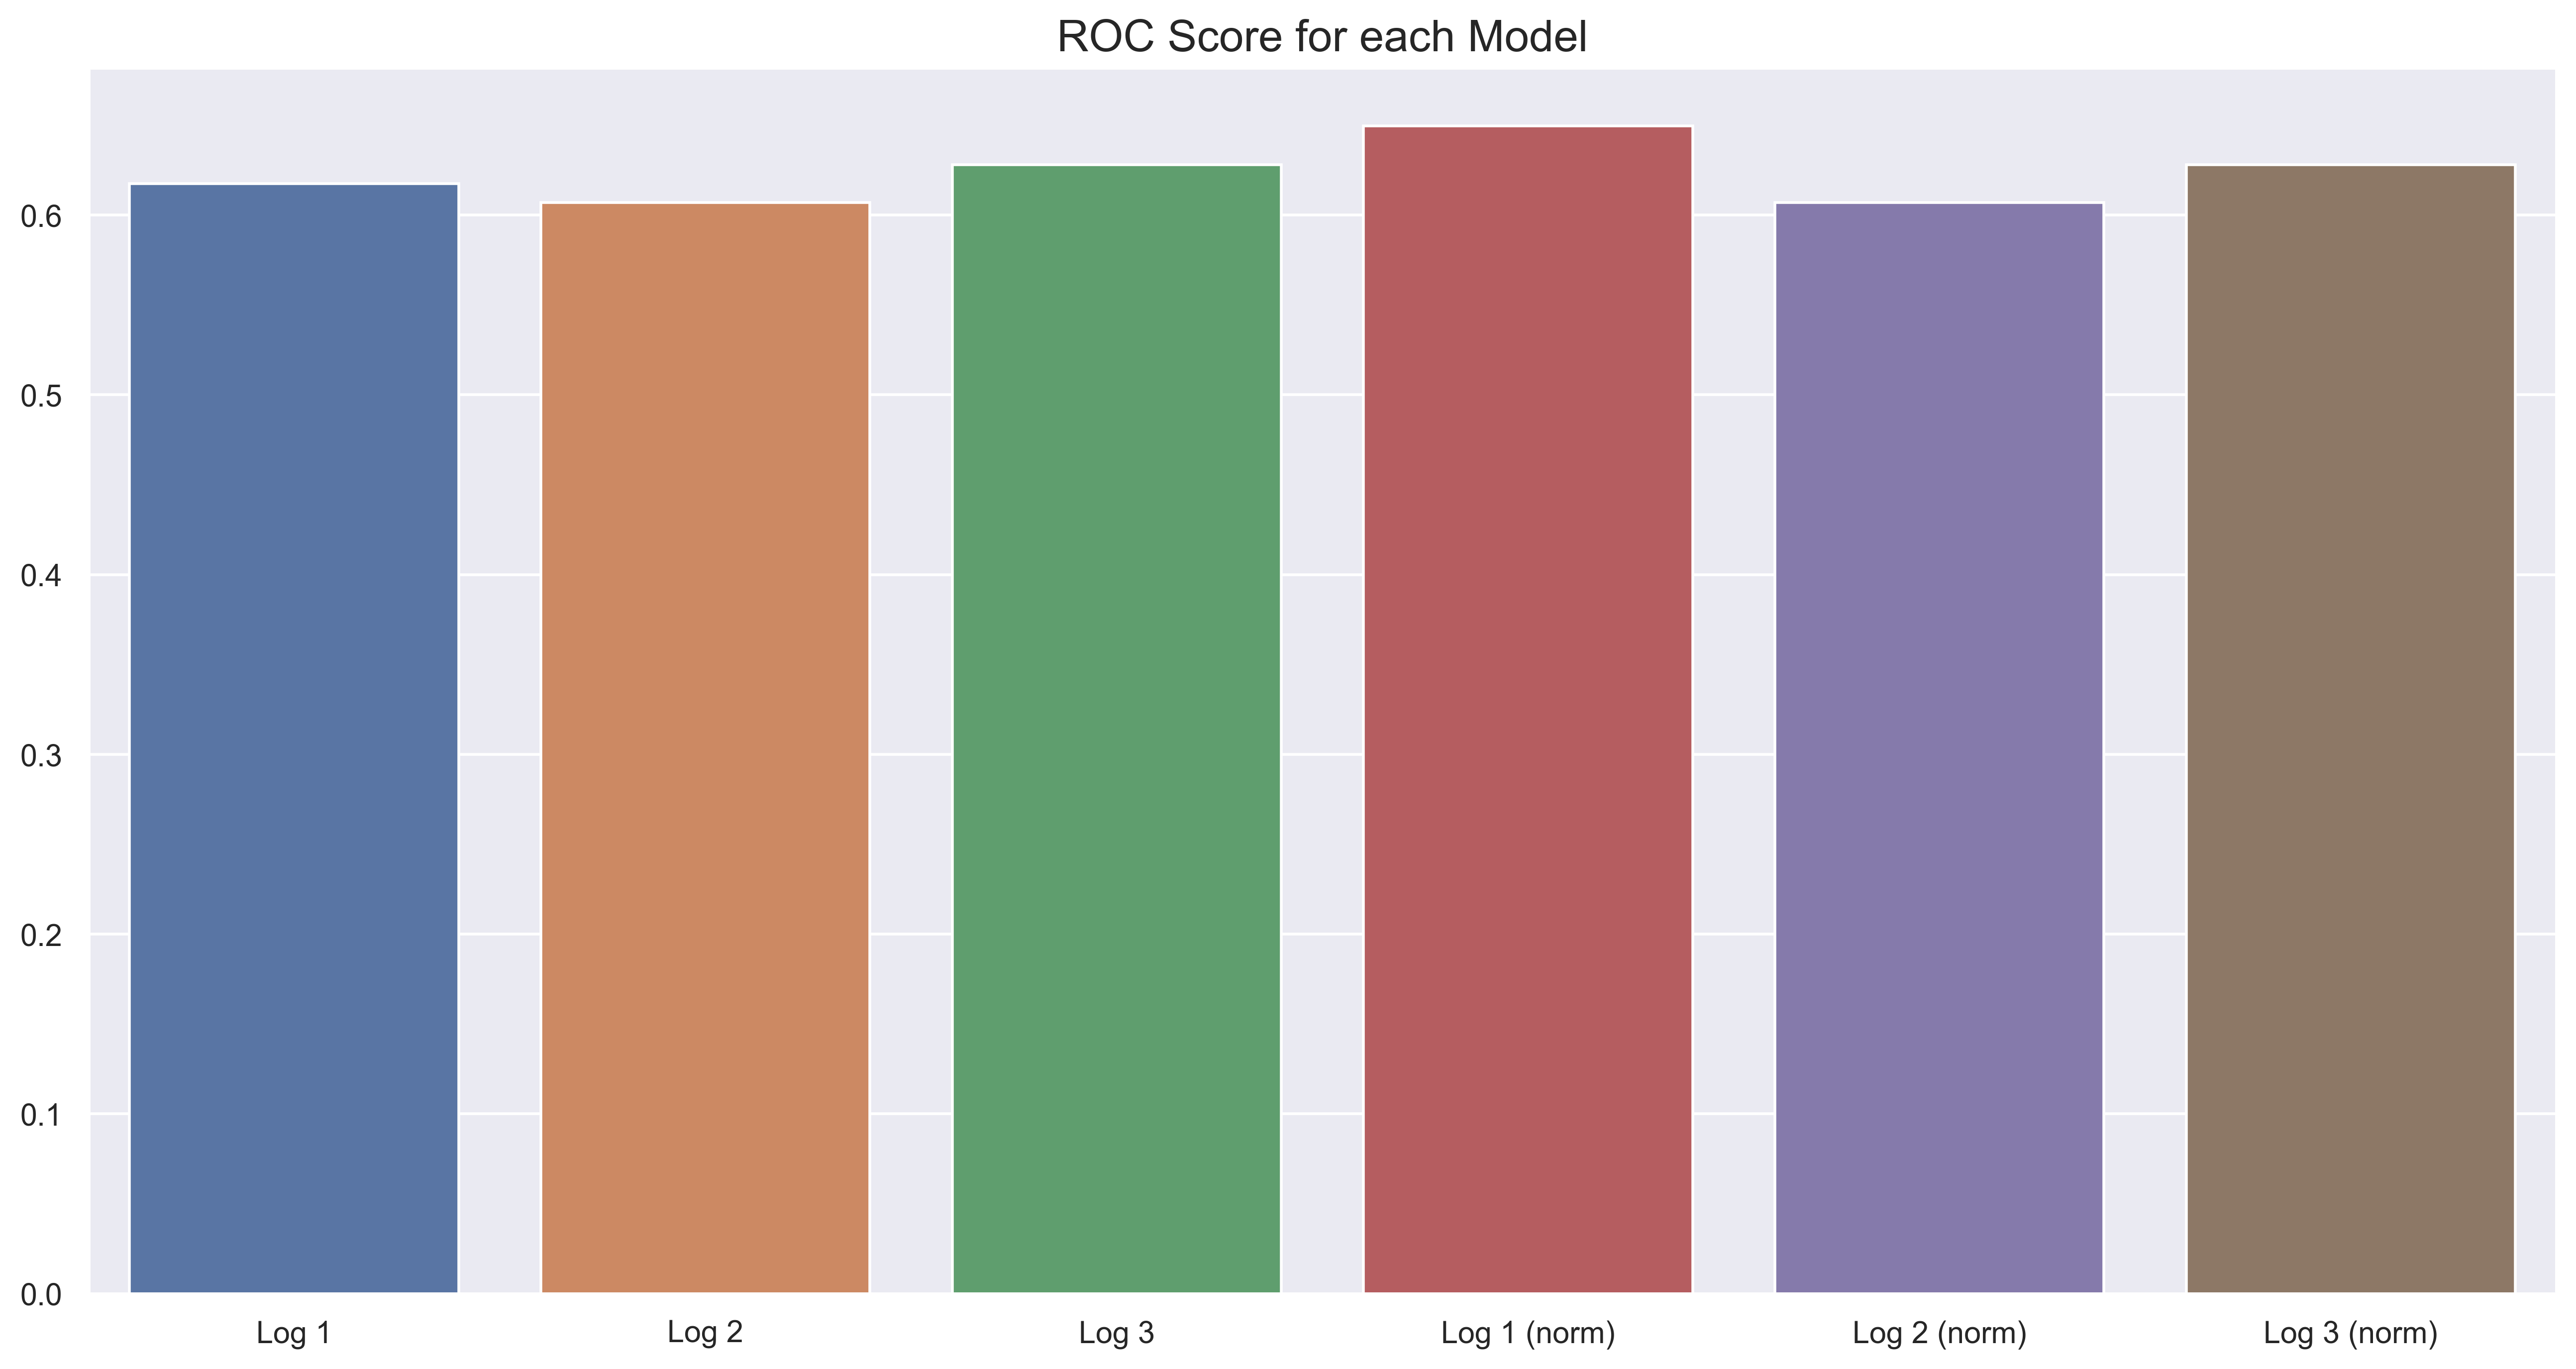


Model Log 1 (norm) has the best ROC Score: 0.6495851892508074


In [26]:
# Compare ROC score for each model with a barplot
sns.barplot(x=['Log 1', 'Log 2', 'Log 3', 'Log 1 (norm)', 'Log 2 (norm)', 'Log 3 (norm)'],
            y=[logit0_roc_auc, logit1_roc_auc, logit2_roc_auc, logit0_st_roc_auc, logit1_st_roc_auc, logit2_st_roc_auc])
plt.title('ROC Score for each Model', size=16)
plt.show()
print()
print('Model Log 1 (norm) has the best ROC Score:', logit0_st_roc_auc)